In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import zipfile
import cv2

# Transformers vs CNNs for Land-Use Classification
## Exploratory Data Analysis (EDA)

### Project Overview
- Comparing Vision Transformers and CNNs for Satellite Imagery Classification
- Datasets: EuroSAT and UC Merced Land Use

In [11]:
# Dataset Classes
EUROSAT_CLASSES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 
    'Highway', 'Industrial', 'Pasture', 
    'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

UC_MERCED_CLASSES = [
    'agricultural', 'airplane', 'baseballdiamond', 'beach', 
    'buildings', 'chaparral', 'denseresidential', 'forest', 
    'freeway', 'golfcourse', 'harbor', 'intersection', 
    'mediumresidential', 'mobilehomepark', 'overpass', 
    'parkinglot', 'river', 'runway', 'sparseresidential', 
    'storagetanks', 'tenniscourt'
]

In [12]:
print("Starting EDA for Transformers vs CNNs in Land-Use Classification")

Starting EDA for Transformers vs CNNs in Land-Use Classification


In [13]:
# Display dataset information
print("\n== Dataset Information ==")
print(f"EuroSAT Classes: {len(EUROSAT_CLASSES)}")
print(f"UC Merced Classes: {len(UC_MERCED_CLASSES)}")


== Dataset Information ==
EuroSAT Classes: 10
UC Merced Classes: 21


In [15]:
def get_dataset_statistics(dataset_path, classes, dataset_type):
    """
    Get statistics about the dataset including number of images per class.
    Adjusts paths based on dataset type (EuroSAT or UC Merced).
    """
    stats = {}
    total_images = 0
    class_counts = {}
    
    for class_name in classes:
        if dataset_type == 'EuroSAT':
            class_dir = os.path.join(dataset_path, class_name)
        elif dataset_type == 'UCMerced':
            class_dir = os.path.join(dataset_path, 'Images', class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory for class {class_name} not found")
            continue
                
        images = [f for f in os.listdir(class_dir) if f.endswith(('.tif', '.jpg'))]
        count = len(images)
        class_counts[class_name] = count
        total_images += count
    
    stats['total_images'] = total_images
    stats['class_counts'] = class_counts
    
    return stats

In [16]:
# Get dataset statistics
print("\n== Getting Dataset Statistics ==")
eurosat_stats = get_dataset_statistics("./EuroSAT_RGB/", EUROSAT_CLASSES, "EuroSAT")
ucmerced_stats = get_dataset_statistics("./UCMerced_LandUse/", UC_MERCED_CLASSES, "UCMerced")
print(f"\nEuroSAT: {eurosat_stats['total_images']} total images")
print(f"UC Merced: {ucmerced_stats['total_images']} total images")


== Getting Dataset Statistics ==

EuroSAT: 27000 total images
UC Merced: 2100 total images


In [17]:
def plot_class_distribution_actual(class_counts):
    """
    Plot actual class distribution from the dataset
    """
    plt.figure(figsize=(14, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.bar(range(len(classes)), counts)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


== Plotting Class Distributions ==


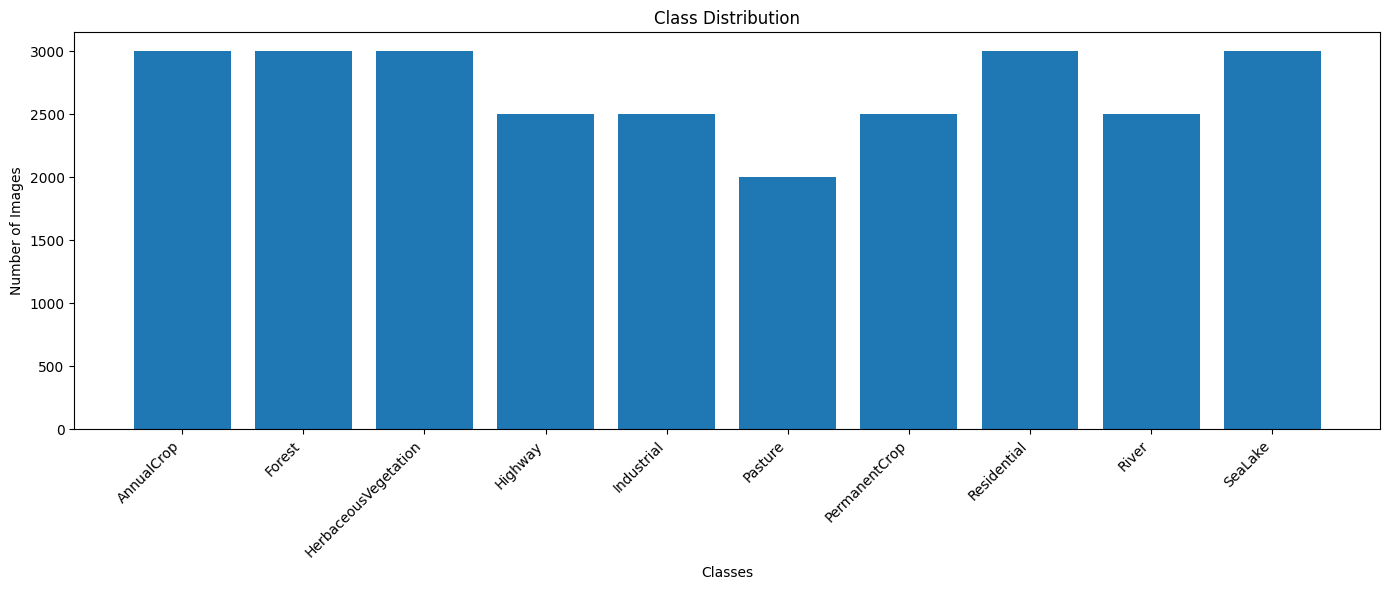

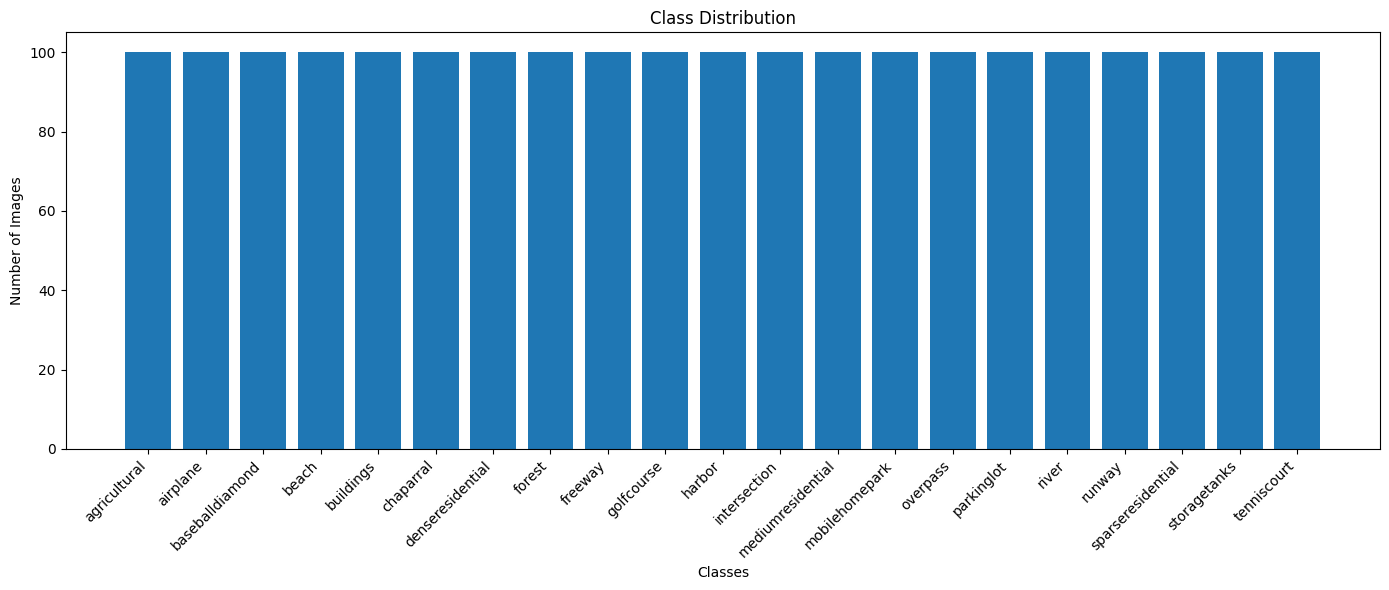

In [18]:
# Plot class distributions
print("\n== Plotting Class Distributions ==")
plot_class_distribution_actual(eurosat_stats['class_counts'])
plot_class_distribution_actual(ucmerced_stats['class_counts'])

In [26]:
def display_sample_images(dataset_path, classes, samples_per_class=3, dataset_name="EuroSAT"):
    """
    Display sample images from each class
    """
    num_classes = len(classes)
    fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(20, 4*samples_per_class))
    
    for i, class_name in enumerate(classes):
        if dataset_name == "EuroSAT":
            class_dir = os.path.join(dataset_path, class_name)
        elif dataset_name == "UCMerced":
            class_dir = os.path.join(dataset_path, "Images", class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory for class {class_name} not found")
            continue
                
        images = [f for f in os.listdir(class_dir) if f.endswith(('.tif', '.jpg'))]
        
        # Select random samples
        samples = np.random.choice(images, min(samples_per_class, len(images)), replace=False)
        
        for j, sample in enumerate(samples):
            img_path = os.path.join(class_dir, sample)
            img = load_img(img_path)
            
            if samples_per_class == 1:
                ax = axes[i]
            else:
                ax = axes[j, i]
                
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


== Displaying Sample Images ==
EuroSAT Samples:


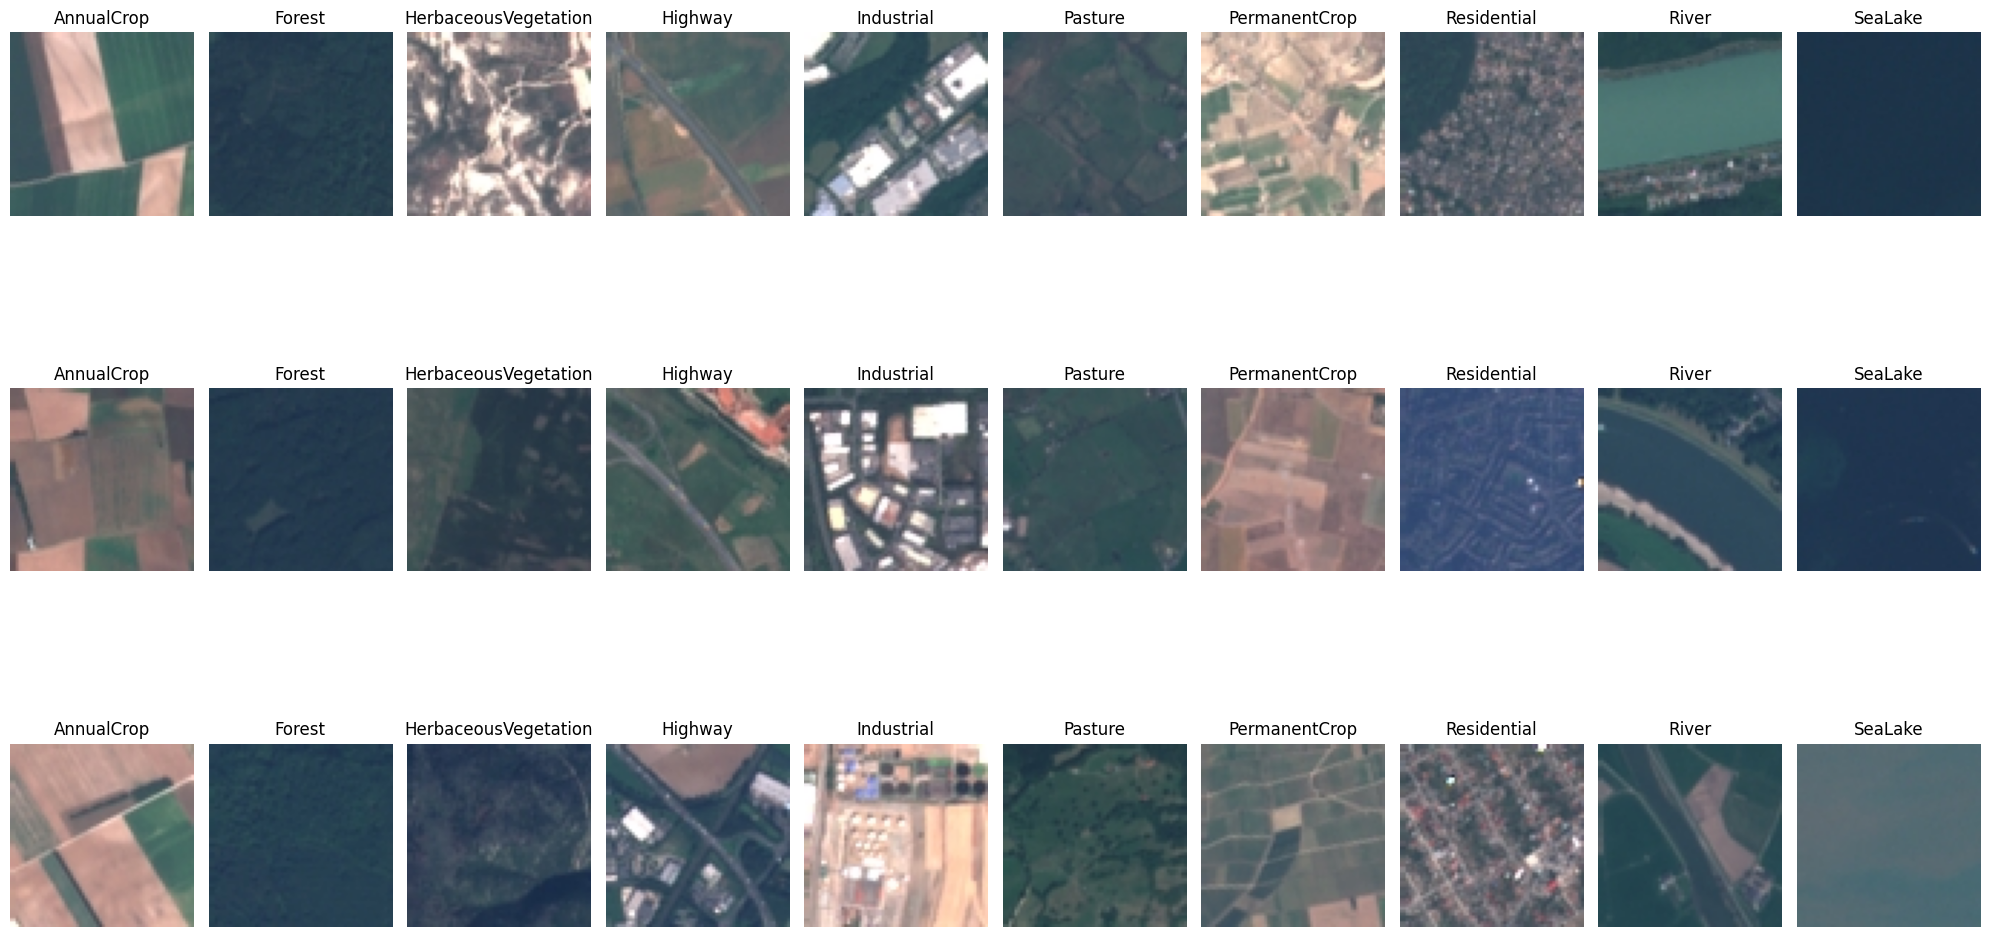

UC Merced Samples:


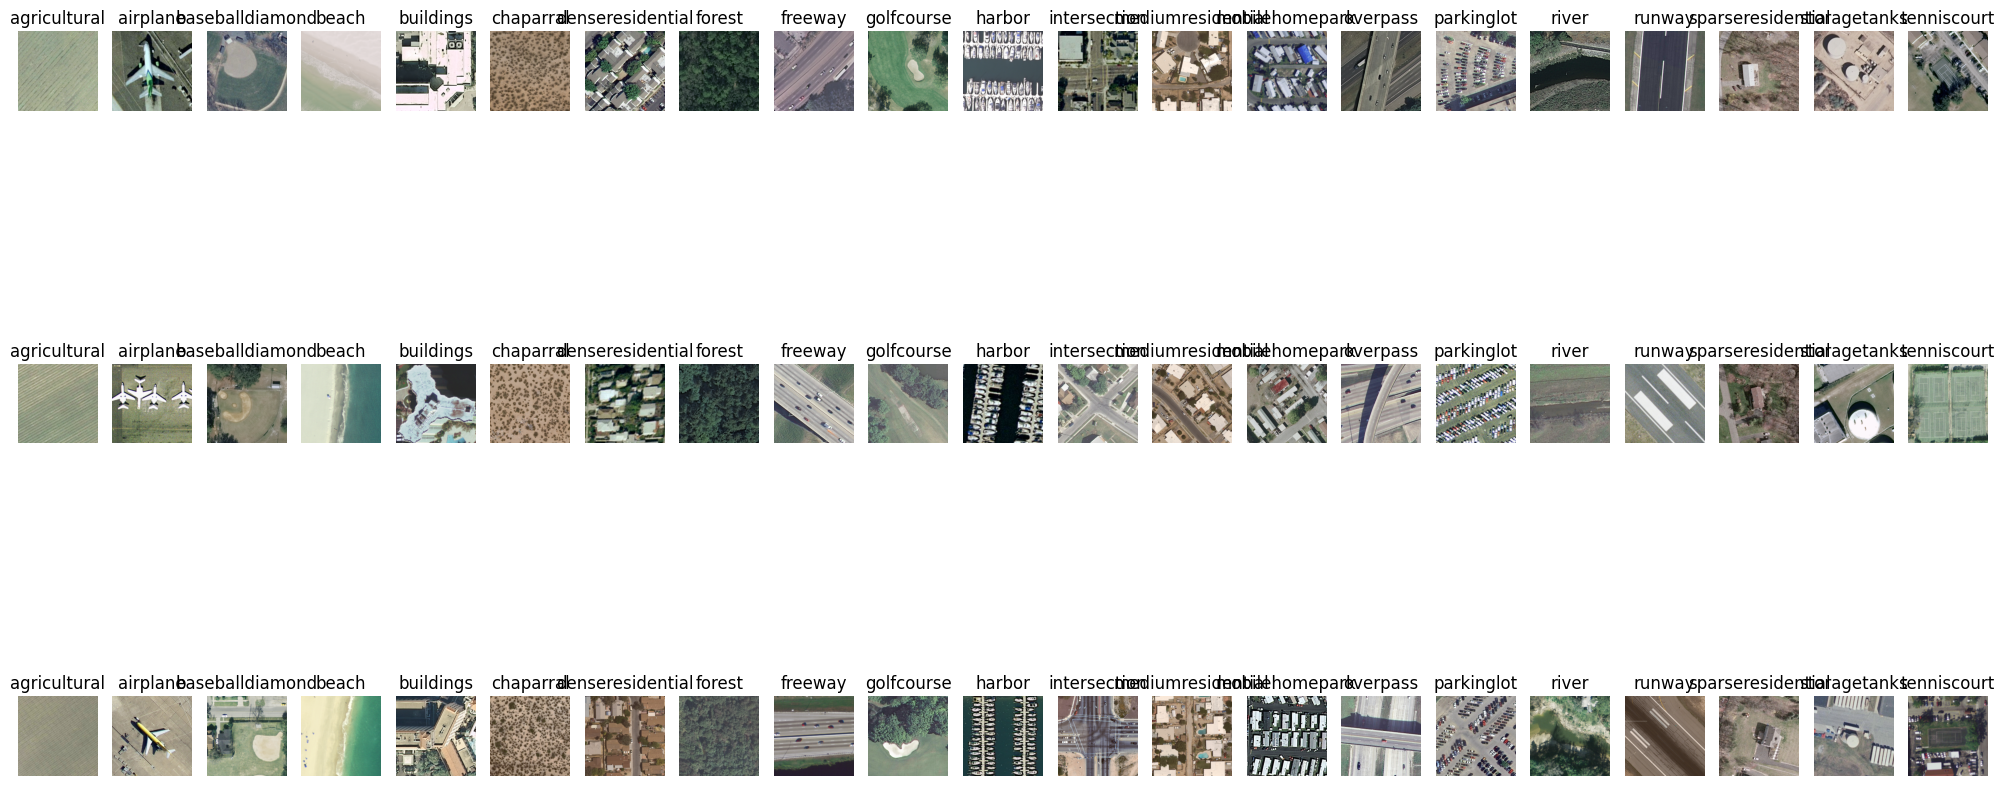

In [28]:
# Display sample images
print("\n== Displaying Sample Images ==")
print("EuroSAT Samples:")
display_sample_images("./EuroSAT_RGB/", EUROSAT_CLASSES, samples_per_class=3, dataset_name="EuroSAT")
print("UC Merced Samples:")
display_sample_images("./UCMerced_LandUse/", UC_MERCED_CLASSES, samples_per_class=3, dataset_name="UCMerced")

In [29]:
# Image Analysis Functions
def analyze_image_characteristics(image_path):
    """
    Analyze basic characteristics of an image
    """
    img = load_img(image_path)
    img_array = img_to_array(img)
    
    return {
        'shape': img_array.shape,
        'mean_pixel_intensity': np.mean(img_array),
        'std_pixel_intensity': np.std(img_array),
        'min_pixel_value': np.min(img_array),
        'max_pixel_value': np.max(img_array)
    }

In [37]:
def compare_image_characteristics(eurosat_path, ucmerced_path):
    """
    Compare image characteristics between EuroSAT and UC Merced datasets
    """
    # Sample image from EuroSAT
    eurosat_sample = None
    for class_name in EUROSAT_CLASSES:
        class_dir = os.path.join(eurosat_path, class_name)
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith(('.tif', '.jpg'))]
            if images:
                eurosat_sample = os.path.join(class_dir, images[0])
                break
    
    # Sample image from UC Merced
    ucmerced_sample = None
    for class_name in UC_MERCED_CLASSES:
        class_dir = os.path.join(ucmerced_path, "Images", class_name)
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith(('.tif', '.jpg'))]
            if images:
                ucmerced_sample = os.path.join(class_dir, images[0])
                break
    
    if eurosat_sample and ucmerced_sample:
        eurosat_img = load_img(eurosat_sample)
        ucmerced_img = load_img(ucmerced_sample)
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(eurosat_img)
        ax[0].set_title(f'EuroSAT: {eurosat_img.size}px')
        ax[0].axis('off')
        
        ax[1].imshow(ucmerced_img)
        ax[1].set_title(f'UC Merced: {ucmerced_img.size}px')
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Analyze characteristics
        eurosat_chars = analyze_image_characteristics(eurosat_sample)
        ucmerced_chars = analyze_image_characteristics(ucmerced_sample)
        
        print("EuroSAT Image Characteristics:")
        for key, value in eurosat_chars.items():
            print(f"  {key}: {value}")
            
        print("\nUC Merced Image Characteristics:")
        for key, value in ucmerced_chars.items():
            print(f"  {key}: {value}")


== Comparing Image Characteristics ==


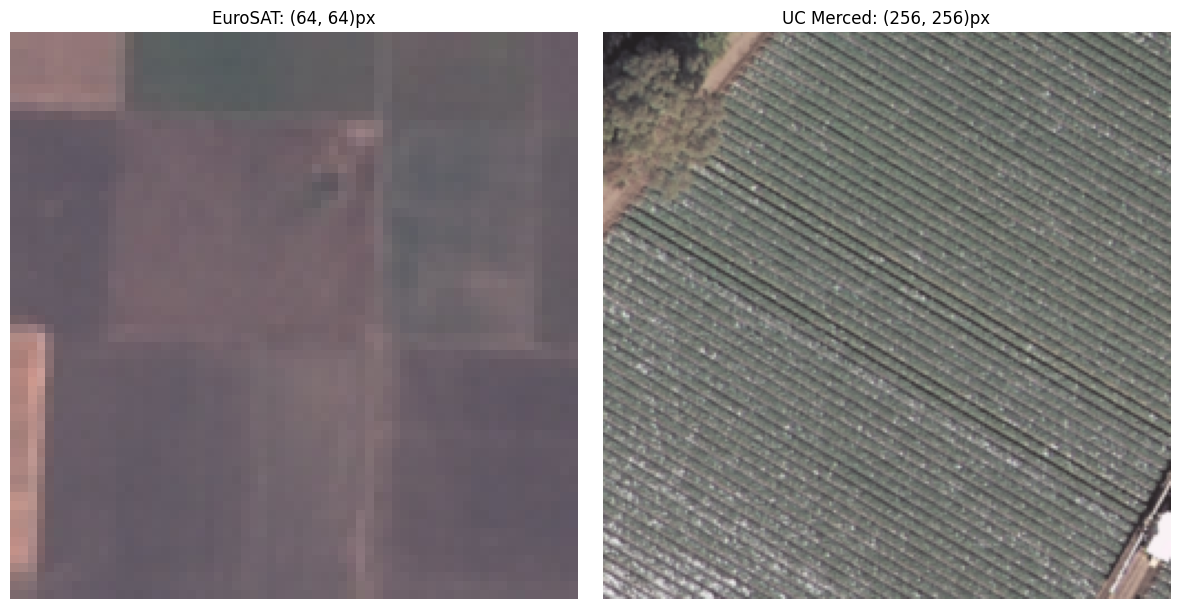

EuroSAT Image Characteristics:
  shape: (64, 64, 3)
  mean_pixel_intensity: 103.800048828125
  std_pixel_intensity: 12.191158294677734
  min_pixel_value: 82.0
  max_pixel_value: 204.0

UC Merced Image Characteristics:
  shape: (256, 256, 3)
  mean_pixel_intensity: 114.90157318115234
  std_pixel_intensity: 22.38842010498047
  min_pixel_value: 33.0
  max_pixel_value: 253.0


In [40]:
# Compare image characteristics
print("\n== Comparing Image Characteristics ==")
compare_image_characteristics("./EuroSAT_RGB/", "./UCMerced_LandUse/")

In [43]:
def analyze_spectral_distributions(dataset_path, classes, samples_per_class=50):
    """
    Analyze RGB channel distributions across different land use classes
    """
    channel_means = {'R': [], 'G': [], 'B': []}
    channel_stds = {'R': [], 'G': [], 'B': []}
    class_labels = []
    
    for class_name in classes:
        # Adjust directory path based on dataset structure
        class_dir = os.path.join(dataset_path, "Images", class_name) if "UCMerced" in dataset_path else os.path.join(dataset_path, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory for class {class_name} not found")
            continue
                
        images = [f for f in os.listdir(class_dir) if f.endswith(('.tif', '.jpg'))]
        
        # Select random samples
        samples = np.random.choice(images, min(samples_per_class, len(images)), replace=False)
        
        class_r_means = []
        class_g_means = []
        class_b_means = []
        class_r_stds = []
        class_g_stds = []
        class_b_stds = []
        
        for sample in samples:
            img_path = os.path.join(class_dir, sample)
            img = load_img(img_path)
            img_array = img_to_array(img) / 255.0  # Normalize
            
            # Calculate mean and std for each channel
            class_r_means.append(np.mean(img_array[:,:,0]))
            class_g_means.append(np.mean(img_array[:,:,1]))
            class_b_means.append(np.mean(img_array[:,:,2]))
            
            class_r_stds.append(np.std(img_array[:,:,0]))
            class_g_stds.append(np.std(img_array[:,:,1]))
            class_b_stds.append(np.std(img_array[:,:,2]))
            
            class_labels.append(class_name)
        
        # Average for the class
        channel_means['R'].append(np.mean(class_r_means))
        channel_means['G'].append(np.mean(class_g_means))
        channel_means['B'].append(np.mean(class_b_means))
        
        channel_stds['R'].append(np.mean(class_r_stds))
        channel_stds['G'].append(np.mean(class_g_stds))
        channel_stds['B'].append(np.mean(class_b_stds))
    
    # Create DataFrame for visualization
    df_means = pd.DataFrame({
        'Class': classes,
        'Red_Mean': channel_means['R'],
        'Green_Mean': channel_means['G'],
        'Blue_Mean': channel_means['B'],
        'Red_Std': channel_stds['R'],
        'Green_Std': channel_stds['G'],
        'Blue_Std': channel_stds['B']
    })
    
    # Plot RGB channel means by class
    plt.figure(figsize=(14, 6))
    x = np.arange(len(classes))
    width = 0.25
    
    plt.bar(x - width, df_means['Red_Mean'], width, label='Red Channel', color='red', alpha=0.7)
    plt.bar(x, df_means['Green_Mean'], width, label='Green Channel', color='green', alpha=0.7)
    plt.bar(x + width, df_means['Blue_Mean'], width, label='Blue Channel', color='blue', alpha=0.7)
    
    plt.xlabel('Classes')
    plt.ylabel('Mean Channel Value')
    plt.title('RGB Channel Means by Class')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df_means


== Analyzing Spectral Distributions ==
EuroSAT Spectral Distributions:


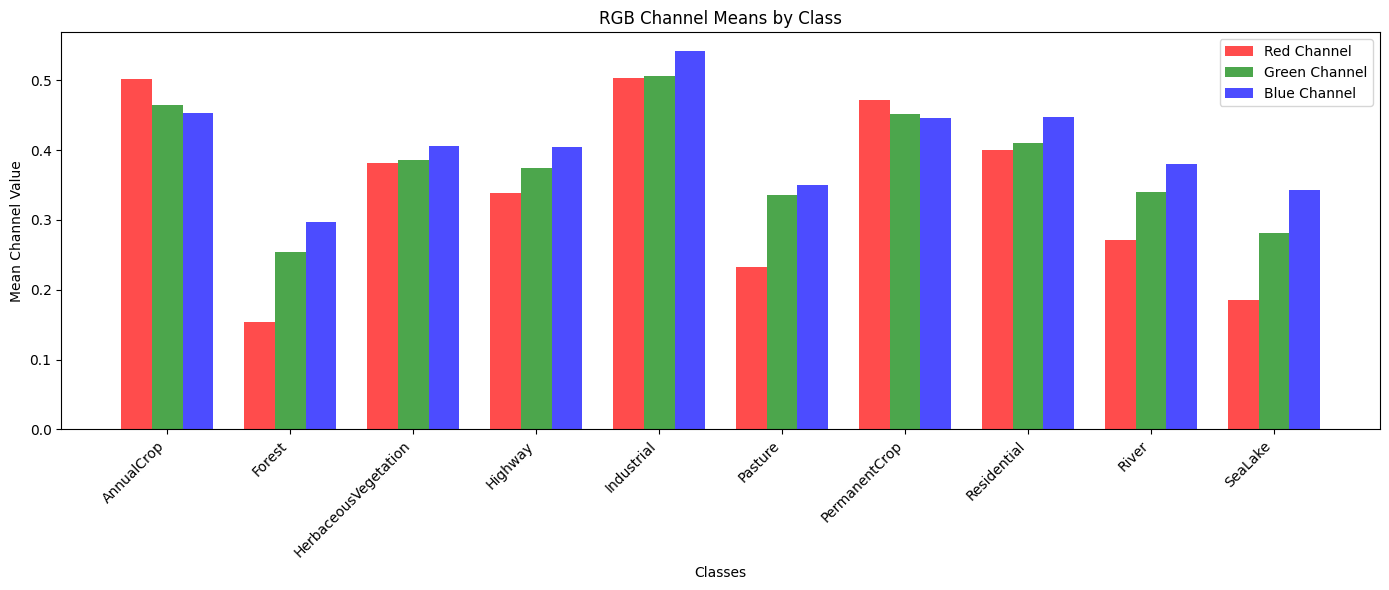

UC Merced Spectral Distributions:


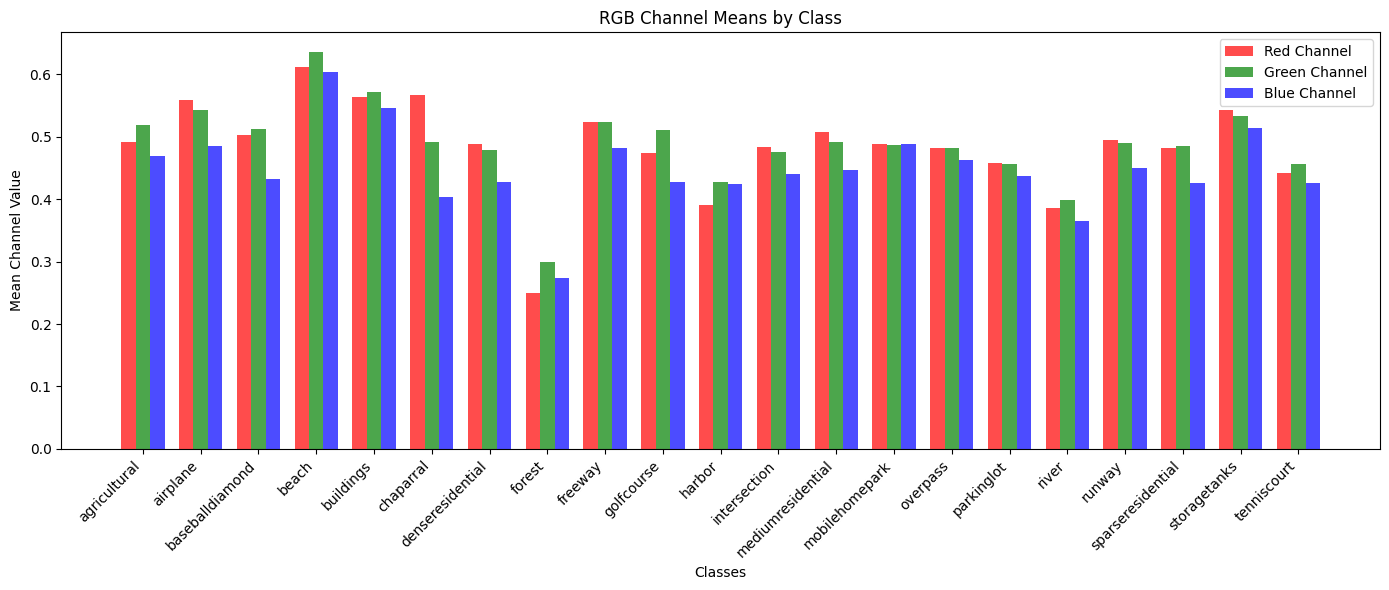

In [52]:
# Analyze spectral distributions
print("\n== Analyzing Spectral Distributions ==")
print("EuroSAT Spectral Distributions:")
eurosat_spectral = analyze_spectral_distributions("./EuroSAT_RGB/", EUROSAT_CLASSES)
print("UC Merced Spectral Distributions:")
ucmerced_spectral = analyze_spectral_distributions("./UCMerced_LandUse/", UC_MERCED_CLASSES)

In [49]:
def analyze_image_complexity(dataset_path, classes, samples_per_class=10):
    """
    Analyze image complexity using edge detection
    """
    
    complexity_scores = []
    class_labels = []
    
    for class_name in classes:
        # Adjust directory path based on dataset structure
        if 'EuroSAT' in dataset_path:
            class_dir = os.path.join(dataset_path, class_name)
        elif 'UCMerced' in dataset_path:
            class_dir = os.path.join(dataset_path, 'Images', class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory for class {class_name} not found")
            continue
                
        images = [f for f in os.listdir(class_dir) if f.endswith(('.tif', '.jpg'))]
        
        # Select random samples
        samples = np.random.choice(images, min(samples_per_class, len(images)), replace=False)
        
        for sample in samples:
            img_path = os.path.join(class_dir, sample)
            img = cv2.imread(img_path)
            
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Edge detection
            edges = cv2.Canny(gray, 100, 200)
            
            # Calculate complexity (percentage of edge pixels)
            complexity = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
            
            complexity_scores.append(complexity)
            class_labels.append(class_name)
    
    # Plot complexity distribution by class
    plt.figure(figsize=(14, 6))
    sns.boxplot(x=class_labels, y=complexity_scores)
    plt.title('Image Complexity by Class')
    plt.xlabel('Class')
    plt.ylabel('Complexity Score (Edge Density)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return complexity_scores, class_labels


== Analyzing Image Complexity ==
EuroSAT Complexity:


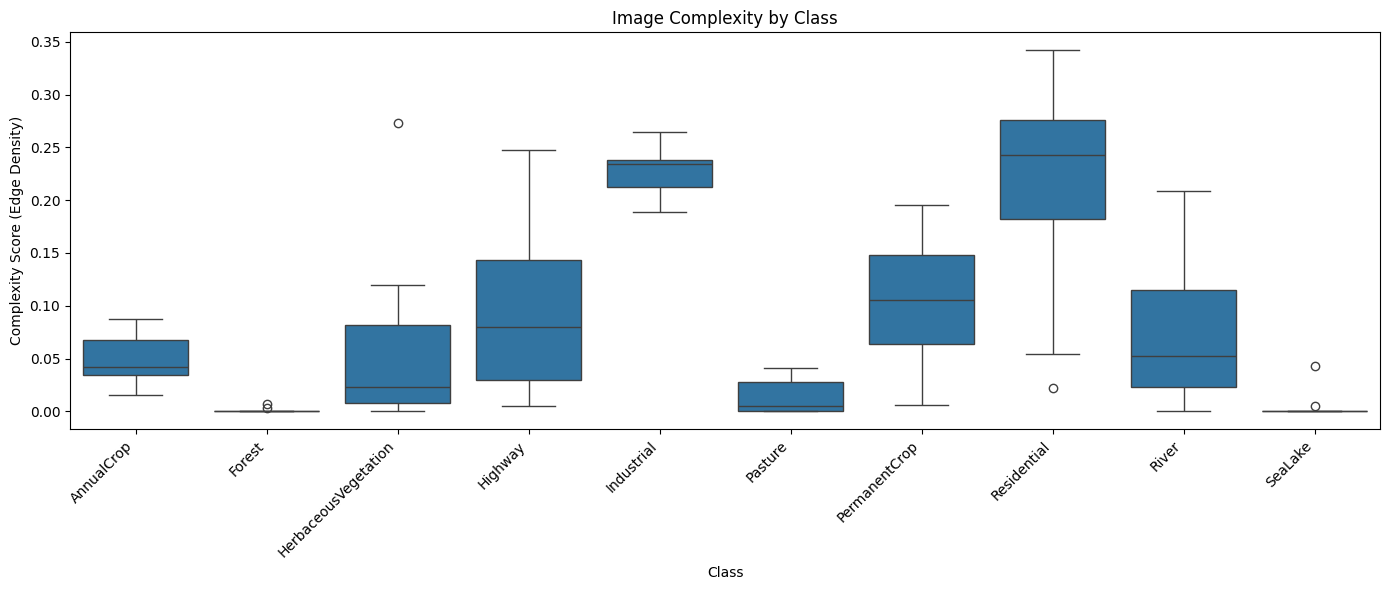

UC Merced Complexity:


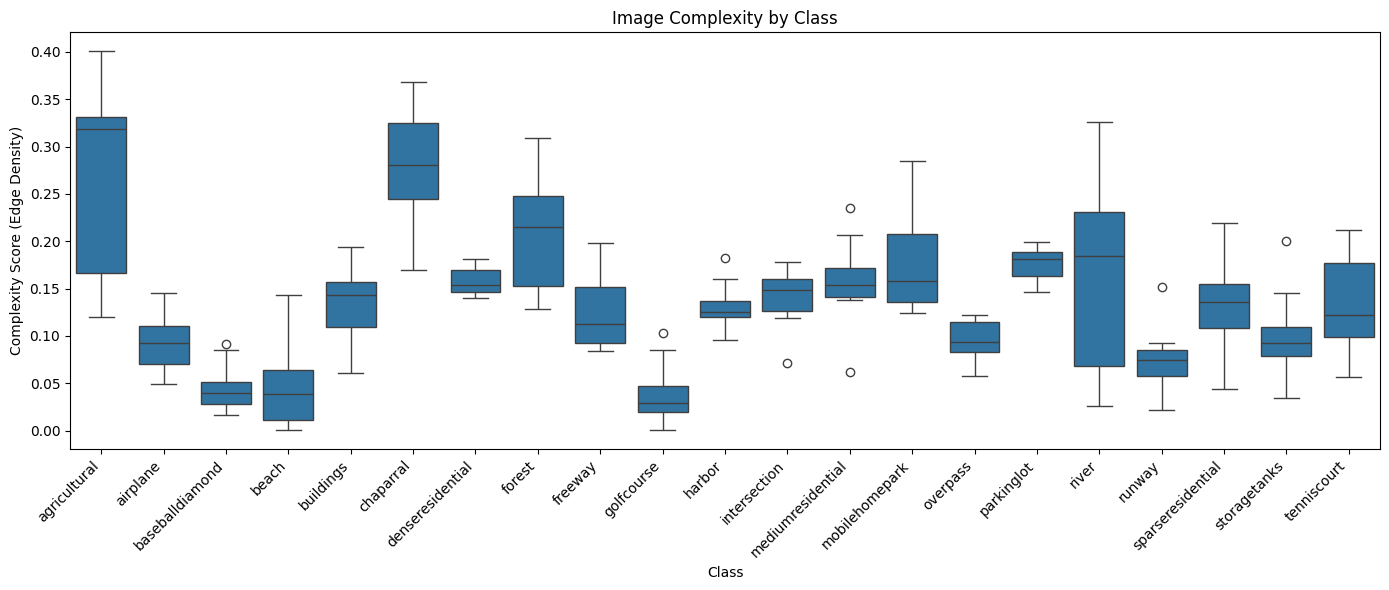

In [50]:
# Analyze image complexity
print("\n== Analyzing Image Complexity ==")
print("EuroSAT Complexity:")
eurosat_complexity, eurosat_labels = analyze_image_complexity("./EuroSAT_RGB/", EUROSAT_CLASSES)
print("UC Merced Complexity:")
ucmerced_complexity, ucmerced_labels = analyze_image_complexity("./UCMerced_LandUse/", UC_MERCED_CLASSES)


In [53]:
print("\nEDA Complete!")


EDA Complete!
